# Successor Representation Learning Experiments

In [1]:
from neuronav.envs.grid_env import GridEnv, GridSize
from neuronav.agents.td_agents import TDSR
from neuronav.envs.grid_topographies import GridTopography
from neuronav.utils import run_episode
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

### Loading the environment

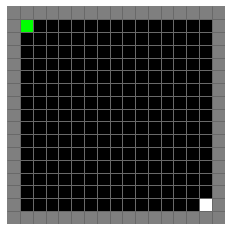

In [2]:
env = GridEnv(topography=GridTopography.empty, grid_size=GridSize.large)
obs = env.reset()
env.render()

### Visualizing the agent's value function

In [3]:
num_episodes = 1000
num_steps = 100

agent = TDSR(env.state_size, env.action_space.n, lr=1e-1, poltype="egreedy", epsilon=0.2)

for _ in range(num_episodes):
    agent, _ = run_episode(env, agent, num_steps, random_start=True)

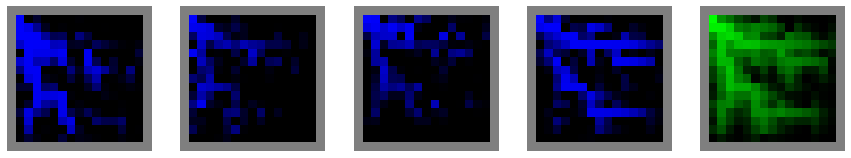

In [4]:
y = 5

fig, axs = plt.subplots(1, y, figsize=(y*3, 3))

for j in range(y):
    axs[j].axis("off")
    b = env.grid(render_objects=False)
    if j < y - 1:
        a = agent.Q[j].reshape(env.grid_size, env.grid_size)
        b[:,:,2] += np.clip(np.sqrt(a), 0, 1)
    else:
        a = np.mean(agent.Q, axis=0).reshape(env.grid_size, env.grid_size)
        b[:,:,1] += np.clip(np.sqrt(a), 0, 1)
    axs[j].imshow(b)

### Analyzing the successor representation

In [5]:
agent = TDSR(env.state_size, env.action_space.n, lr=1e-1, poltype="egreedy", epsilon=1.0, goal_biased_sr=False)
num_episodes = 1000
num_steps = 100

for i in range(num_episodes):
    agent, _ = run_episode(env, agent, num_steps, random_start=True, goal_pos=[0,0])

m_map = {}
for state in range(env.state_size):
    if agent.M[:,state].mean(0).sum() != 1:
        m_map[state] = agent.M.mean(0)[state]
m_map = np.stack(list(m_map.values()))

#### Visualizing the agent's successor "place cells"

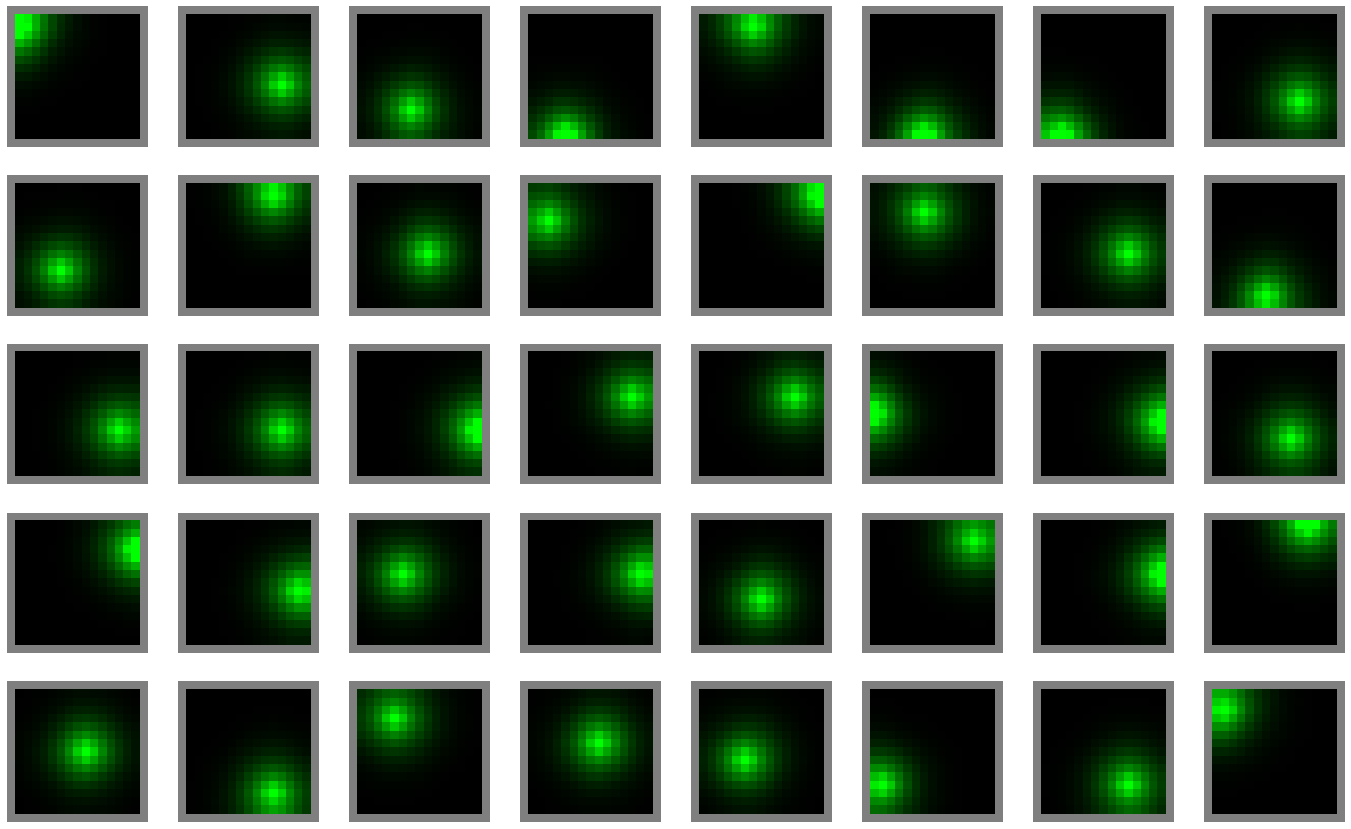

In [6]:
x, y= 8, 5

fig, axs = plt.subplots(y, x, figsize=(x*3, y*3))

np.random.shuffle(m_map)

for i in range(x):
    for j in range(y):
        axs[j,i].axis("off")
        a = m_map[i * y + j].reshape(env.grid_size, env.grid_size)
        b = env.grid(render_objects=False)
        b[:,:,1] += np.clip(np.power(a,.5), 0, 1)
        axs[j,i].imshow(b)

#### Visualizing the agent's successor "grid cells"

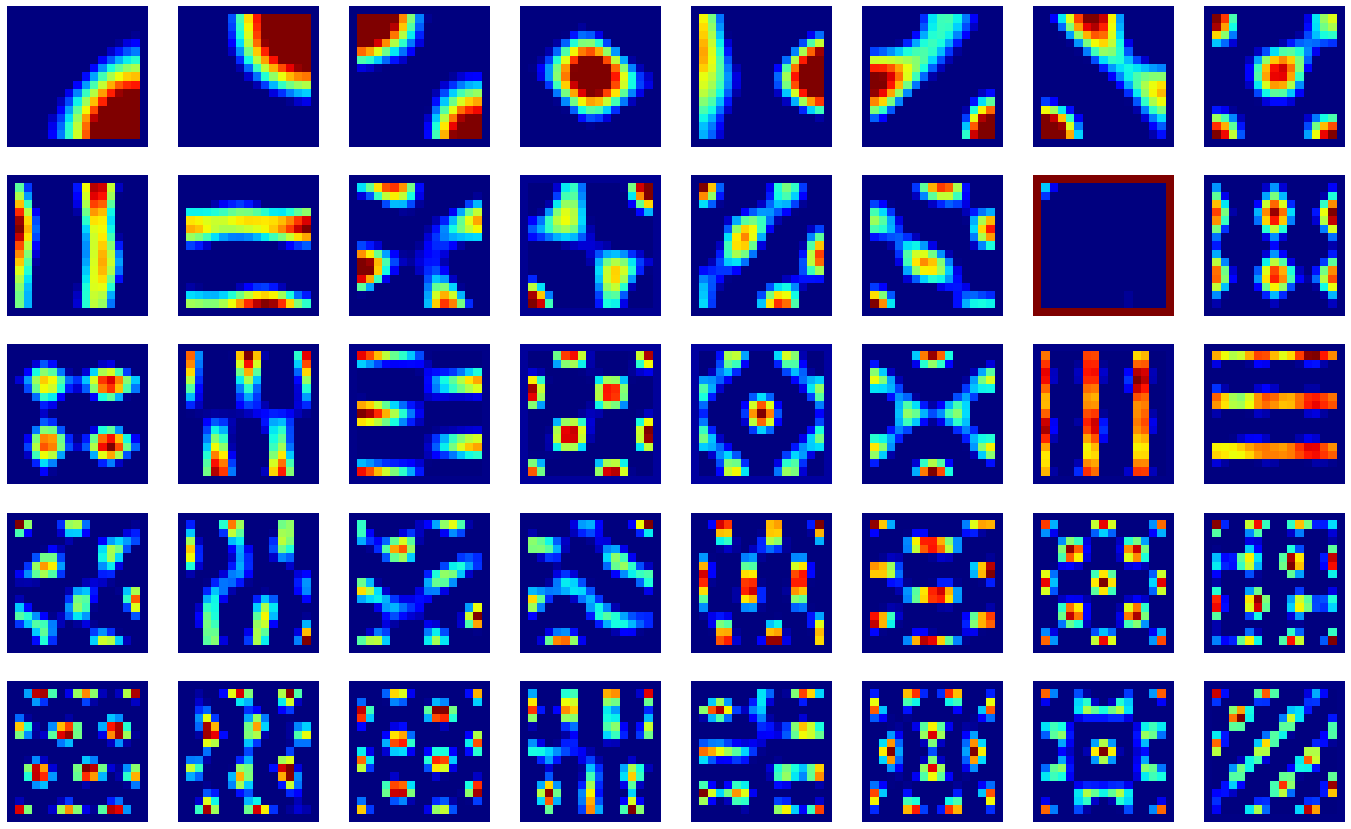

In [7]:
y = 8
x = 5

mean_m = np.mean(agent.M, axis=0)
pca = PCA(n_components=y*x, svd_solver='full')
result = pca.fit_transform(mean_m.T)
result = np.clip(result, 0, 1)

fig, axs = plt.subplots(x, y, figsize=(y*3, x*3))

for j in range(x):
    for i in range(y):
        axs[j,i].axis("off")
        axs[j,i].imshow(result[:,(i+(j*y))].reshape(env.grid_size, env.grid_size), cmap='jet')